In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2024-11-09 11:11:51.552808: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 11:11:51.731963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731125511.832368    5661 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731125511.862598    5661 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 11:11:52.056196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
NEG_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/negative'
POS_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/positive'
ANC_PATH = '/home/leloc/Documents/USTH-B3/Group_project/Model/anchor'

In [4]:
# Negative dataset : https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
for directory in os.listdir('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled'):
    for file in os.listdir(os.path.join('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled', directory)):
        EX_PATH = os.path.join('/home/leloc/Documents/USTH-B3/Group_project/Model/lfw-deepfunneled', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


In [ ]:
# Random but unique name for img
import uuid

In [ ]:
# Use camera
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    #250x250 pixel
    frame = frame[ 200:200+250, 170:170+250, :]
    
    #Collect anchor
    if cv2.waitKey(1) == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    #Collect positive
    if cv2.waitKey(1) == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        

    #Show image
    cv2.imshow('IMAGE', frame)
    
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH +'/*.jpg').take(500)
positive = tf.data.Dataset.list_files(POS_PATH +'/*.jpg').take(500)
negative = tf.data.Dataset.list_files(NEG_PATH +'/*.jpg').take(500)

I0000 00:00:1731125523.780344    5661 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2266 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
img_test = anchor.as_numpy_iterator()
print(img_test.next())

b'/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/36d5c573-7413-11ef-99be-e81f155e7428.jpg'


In [7]:
def preprocess(file_path):
    read_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(read_img)

    img = tf.image.resize(img, (105,105))
    img = img/255.0
    return img

In [8]:
img = preprocess('/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/36d5c573-7413-11ef-99be-e81f155e7428.jpg')

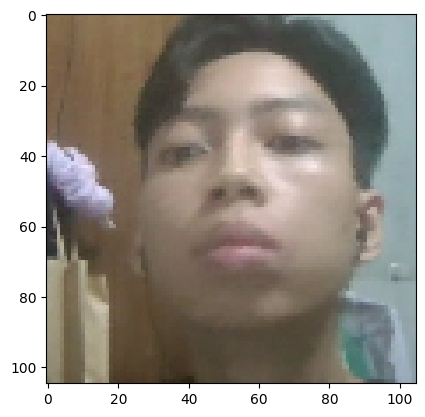

In [9]:
plt.imshow(img)

In [10]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [12]:
try_img = data.as_numpy_iterator()
try_img = try_img.next()
try_img

(b'/home/leloc/Documents/USTH-B3/Group_project/Model/anchor/452508b3-7413-11ef-b7e9-e81f155e7428.jpg',
 b'/home/leloc/Documents/USTH-B3/Group_project/Model/positive/b39ddf59-7413-11ef-b862-e81f155e7428.jpg',
 np.float32(1.0))

In [13]:
def double_check(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)


In [14]:
res = double_check(*try_img)
res

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.52791786, 0.41419235, 0.2965453 ],
         [0.5295918 , 0.41586635, 0.29765907],
         [0.5223978 , 0.4139945 , 0.28673026],
         ...,
         [0.6146481 , 0.69345295, 0.71483475],
         [0.61419237, 0.6965453 , 0.71615314],
         [0.5967343 , 0.6790872 , 0.69869506]],
 
        [[0.5185808 , 0.41325864, 0.29561156],
         [0.51264507, 0.40732294, 0.28965586],
         [0.5168667 , 0.41154462, 0.29361746],
         ...,
         [0.614846  , 0.69803923, 0.7095238 ],
         [0.622409  , 0.7056022 , 0.71708685],
         [0.6112045 , 0.69439775, 0.7058824 ]],
 
        [[0.51261616, 0.418125  , 0.29692987],
         [0.49872616, 0.40423504, 0.28089237],
         [0.5068539 , 0.41236272, 0.28902006],
         ...,
         [0.60097146, 0.6958917 , 0.7072829 ],
         [0.6112045 , 0.70532215, 0.71671337],
         [0.6056956 , 0.69981325, 0.71120447]],
 
        ...,
 
        [[0.53958917, 0.50821656

In [15]:
#build pipline
data = data.map(double_check)
data = data.cache()
data = data.shuffle(buffer_size=2000)

In [16]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [17]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [18]:
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = data.batch(16)
test_data = data.prefetch(8)

## Model

In [25]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [26]:
embed = make_embedding()
embed.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Siamese L1 Distance class
class L1Dist(tf.keras.layers.Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, inputs):
        input_embedding,validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

In [28]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

inp_embed = embed(input_image)
val_embed = embed(validation_image)


siamese_layer = L1Dist()


In [29]:
siamese_layer

<L1Dist name=l1_dist, built=False>

In [30]:
# New version tensor -> not same input and output shape
distances = siamese_layer(embed(input_image), embed(validation_image))
classifier = Dense(1,activation='sigmoid')(distances)

TypeError: too many positional arguments

In [31]:
classifier

NameError: name 'classifier' is not defined

In [32]:
def make_siames_model():
    input_image = Input(name='input_img', shape=(105,105,3))
    validation_image = Input(name='validation_img', shape=(105,105,3))

    siamese_layer = L1Dist()
    siamese_layer.name = 'distance'
    distances = siamese_layer([embed(input_image), embed(validation_image)])

    classifier = Dense(1, activation ='sigmoid')(distances)

    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'Siamese_Network')


In [33]:
siamese_model = make_siames_model()

siamese_model.summary()

Model: "Siamese_Network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distance (L1Dist)   │ (None, 4096)      │          0 │ embedding[4][0],  │
│                     │                   │            │ embedding[5][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ distance[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Trainning


### Set up loss and optimize

In [34]:
binary_cross_loss = tf._losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [35]:
checkpoint_dir = './home/leloc/Documents/USTH-B3/Group_project/Model/trainning_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model =siamese_model)


In [36]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

In [37]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Tách batch thành đầu vào và nhãn
        X = batch[:2]
        y = batch[2]

        # Dự đoán đầu ra từ mô hình
        y_pred = siamese_model(X, training=True)

        # Tính toán mất mát
        loss = binary_cross_loss(y, y_pred)
        print(loss)

    # Tính gradient đối với các tham số có thể huấn luyện
    gradients = tape.gradient(loss, siamese_model.trainable_variables)

    # Áp dụng các gradient vào mô hình
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))

    return loss

        

In [38]:
from tensorflow.keras.metrics import Precision, Recall

In [39]:
def train(data, EPOCH):
    for epoch in range (1, EPOCH + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCH))
        progbar = tf.keras.utils.Progbar(len(data))

        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            y_pred = siamese_model.predict(batch[:2])
            r.update_state(batch[2], y_pred)
            p.update_state(batch[2], y_pred)
            progbar.update(idx+1)
    print(loss.numpy(), r.result().numpy(), p.result().numpy())

    if epoch % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

In [40]:
EPOCH = 50

In [41]:
train(train_data, EPOCH)


 Epoch 1/50


/home/leloc/anaconda3/envs/facial_reg/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_img', 'validation_img']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)


I0000 00:00:1731125624.594021    6173 cuda_dnn.cc:529] Loaded cuDNN version 90300


KeyboardInterrupt: 

In [ ]:
# call model, thử predict -> dimension, test function squeeze, unsqueeze xem biến đổi output nnao


Có GPU


/job:localhost/replica:0/task:0/device:GPU:0
